In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist as pdist
from scipy.spatial.distance import squareform as squareform
from tqdm import tqdm
from itertools import product
import pickle
from scipy.stats import binned_statistic
import seaborn as sns
import pandas as pd


In [ ]:
def Build_Patterns(N_Patt=10,Dim=1,N_CA3=100):

    projections = np.random.rand(Dim,N_CA3)
    projections = projections/np.linalg.norm(projections,ord=1)
    
    pattern_positions = np.random.rand(N_Patt,Dim)
    
    return pattern_positions,projections

def Activate_Pattern(pattern_positions,projections,active_pattern,noise):
    act = (pattern_positions[active_pattern]+ np.random.uniform(-noise,noise,size=pattern_positions.shape[-1]))@ projections 
    return act



def Connections_Init(N_CA3,N_CA1):
    Conn = np.random.rand(N_CA3,N_CA1)
    Conn = Conn/np.linalg.norm(Conn,axis=0,ord=1)
    return Conn

def Compute_Sparsity(Vec):
    sp = (np.mean(Vec))**2/np.mean(Vec**2)
    return sp


def Normalize_Activity(Act,sparsity=0.1):
    th = np.percentile(Act,(1.0-sparsity)*100)
    Act = Act-th
    Act[Act<0] = 0
    Act = Act/np.mean(Act)
    return Act

def Compute_Plasticity(Pre,Post,eta=0.001):
    dw = Pre @ ((Post-np.mean(Post,axis=0)).T)
    dw = dw * eta
    return dw

def Apply_Plasticity(Conn,dw_tot):
    Conn += dw_tot
    Conn[Conn<0] = 0
    Conn = Conn/np.linalg.norm(Conn,axis=0,ord=1)
    Conn[np.isnan(Conn)] = 0
    return Conn

def Add_Noise(vector,sigma):
    vector += np.random.uniform(-sigma,sigma,size = vector.shape)
    return vector


# Baseline

In [101]:
epochs = 50
noise_levels = [0,0.1,0.5,1,2]
dimensions = [1,2,3,10,15]

noise = 0.1 #noise_levels[2]
dim = 2 # dimensions[2]
N_CA3 = 100
N_Patt = 6
spars = 0.6

projections = np.random.normal(0,1,(dim,N_CA3))
projections = projections/np.linalg.norm(projections,ord=1)
lowd_patterns = np.random.normal(0,1,size=(N_Patt,dim))

same_corr = []
other_corr = []
pattern_Act = np.zeros((epochs,N_Patt,N_CA3))
for epoch in range(epochs):
    for pattern in range(N_Patt):
        active_ld_pattern = lowd_patterns[pattern]
        Act = active_ld_pattern @ projections + np.random.normal(0,noise,size=N_CA3) 
        Act = Normalize_Activity(Act,sparsity=spars)
        pattern_Act[epoch,pattern,:] = Act

In [102]:
for epoch1,epoch2,pattern1,pattern2 in product(range(epochs),range(epochs),range(N_Patt),range(N_Patt)):
    data['epoch1'].append(epoch1)
    data['epoch2'].append(epoch2)
    data['pattern1'].append(pattern1)
    data['pattern2'].append(pattern2)
    if pattern1==pattern2:
        data['pattern_label'].append('same pattern')
    else:
        data['pattern_label'].append('cross_pattern')
    data['correlation'].append(np.corrcoef(pattern_Act[epoch1,pattern1],pattern_Act[epoch2,pattern2])[0,1])



data = pd.DataFrame.from_dict(data)

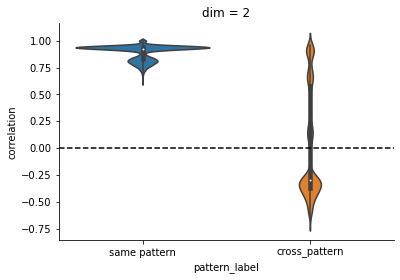

In [103]:
sns.violinplot(data =data, x= 'pattern_label',y='correlation')
sns.despine()
plt.title(f'dim = {dim}')
plt.axhline(y=0,linestyle='--',c='k')

In [118]:
epochs = 50
dimensions = [1,2,3,10,30,50]

noise = 0.1 #noise_levels[2]
N_CA3 = 200
N_Patt = 3
spars = 0.3

data = {'epoch1':[],'epoch2':[],'pattern1':[],'pattern2':[],'pattern_label':[],'correlation':[],'dimension':[]}


for dim in tqdm(dimensions):

    projections = np.random.normal(0,1,(dim,N_CA3))
    projections = projections/np.linalg.norm(projections,ord=1)
    lowd_patterns = np.random.normal(0,1,size=(N_Patt,dim))

    same_corr = []
    other_corr = []
    pattern_Act = np.zeros((epochs,N_Patt,N_CA3))
    for epoch in range(epochs):
        for pattern in range(N_Patt):
            active_ld_pattern = lowd_patterns[pattern]
            Act = active_ld_pattern @ projections + np.random.normal(0,noise,size=N_CA3) 
            Act = Normalize_Activity(Act,sparsity=spars)
            pattern_Act[epoch,pattern,:] = Act

    for epoch1,epoch2,pattern1,pattern2 in product(range(epochs),range(epochs),range(N_Patt),range(N_Patt)):
        data['epoch1'].append(epoch1)
        data['epoch2'].append(epoch2)
        data['pattern1'].append(pattern1)
        data['pattern2'].append(pattern2)
        data['dimension'].append(dim)
        if pattern1==pattern2:
            data['pattern_label'].append('same pattern')
        else:
            data['pattern_label'].append('cross_pattern')
        data['correlation'].append(np.corrcoef(pattern_Act[epoch1,pattern1],pattern_Act[epoch2,pattern2])[0,1])

100%|██████████| 6/6 [00:07<00:00,  1.18s/it]


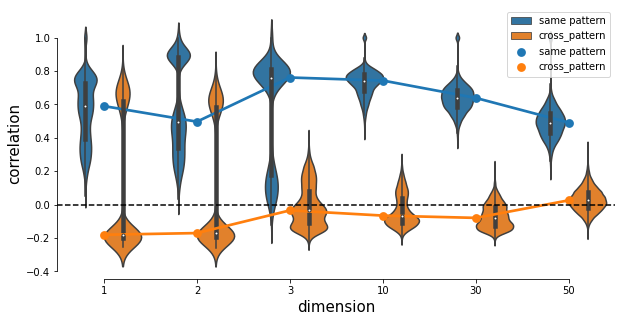

In [119]:
plt.figure(figsize=(10,5))
sns.violinplot(data =data, x='dimension',y='correlation',hue='pattern_label')
sns.pointplot(data =data, x='dimension',y='correlation',hue='pattern_label',estimator=np.median)
sns.despine(trim=True)
plt.xlabel('dimension',fontsize=15)
plt.ylabel('correlation',fontsize=15)

plt.axhline(y=0,linestyle='--',c='k')